## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
# 분야별 데이터셋 내 다중공선성 해결을 위해 각각 불러온다.
target = pd.read_csv('../data/ProcessedData/trash_1520.csv')

pop = pd.read_csv('../data/ProcessedData/인구정보_seoul.csv')
live = pd.read_csv('../data/ProcessedData/주거정보_seoul.csv')
economic = pd.read_csv('../data/ProcessedData/경제정보_seoul.csv')

GJ_pop = pd.read_csv('../data/ProcessedData/인구정보_gwangjin.csv')
GJ_live = pd.read_csv('../data/ProcessedData/주거정보_gwangjin.csv')
GJ_economic = pd.read_csv('../data/ProcessedData/경제정보_gwangjin.csv')

### Normalized Data

In [3]:
columns = [i for i in pop.columns if i not in ['자치구', '년도','행정동']]
pop[columns] = pd.DataFrame(normalize(pop[columns], axis=0), dtype='f')
GJ_pop[columns] = pd.DataFrame(normalize(GJ_pop[columns], axis=0), dtype='f')

columns = [i for i in live.columns if i not in ['자치구', '년도','행정동']]
live[columns] = pd.DataFrame(normalize(live[columns], axis=0), dtype='f')
GJ_live[columns] = pd.DataFrame(normalize(GJ_live[columns], axis=0), dtype='f')

columns = [i for i in economic.columns if i not in ['자치구', '년도','행정동']]
economic[columns] = pd.DataFrame(normalize(economic[columns], axis=0), dtype='f')
GJ_economic[columns] = pd.DataFrame(normalize(GJ_economic[columns], axis=0), dtype='f')

In [4]:
# 선택된 변수들로 데이터를 병합한다.
seoul = target.merge(pop.rename(columns={'1인세대수':'one세대수'}), on=['자치구','년도'])\
        .merge(live, on=['자치구','년도']).merge(economic, on=['자치구','년도'])

# 예년의 값으로 후년의 쓰레기량을 설명하는 통계 모델을 만들고 예측값을 위험지표로 사용하고자 한다.
ease = seoul.query('년도 > 2017')[['자치구','년도','일반쓰레기량','재활용폐기물량','음식물류폐기물량']]
ease['년도'] = ease['년도']-1

seoul = seoul.query('년도 < 2020').drop(['일반쓰레기량','재활용폐기물량','음식물류폐기물량'], axis=1)\
       .merge(ease, on=['자치구','년도'])
seoul.shape

(75, 93)

In [5]:
gwangjin = GJ_pop.rename(columns={'1인세대수':'one세대수'}).merge(GJ_live, on='행정동').merge(GJ_economic, on='행정동')
gwangjin.shape

(15, 89)

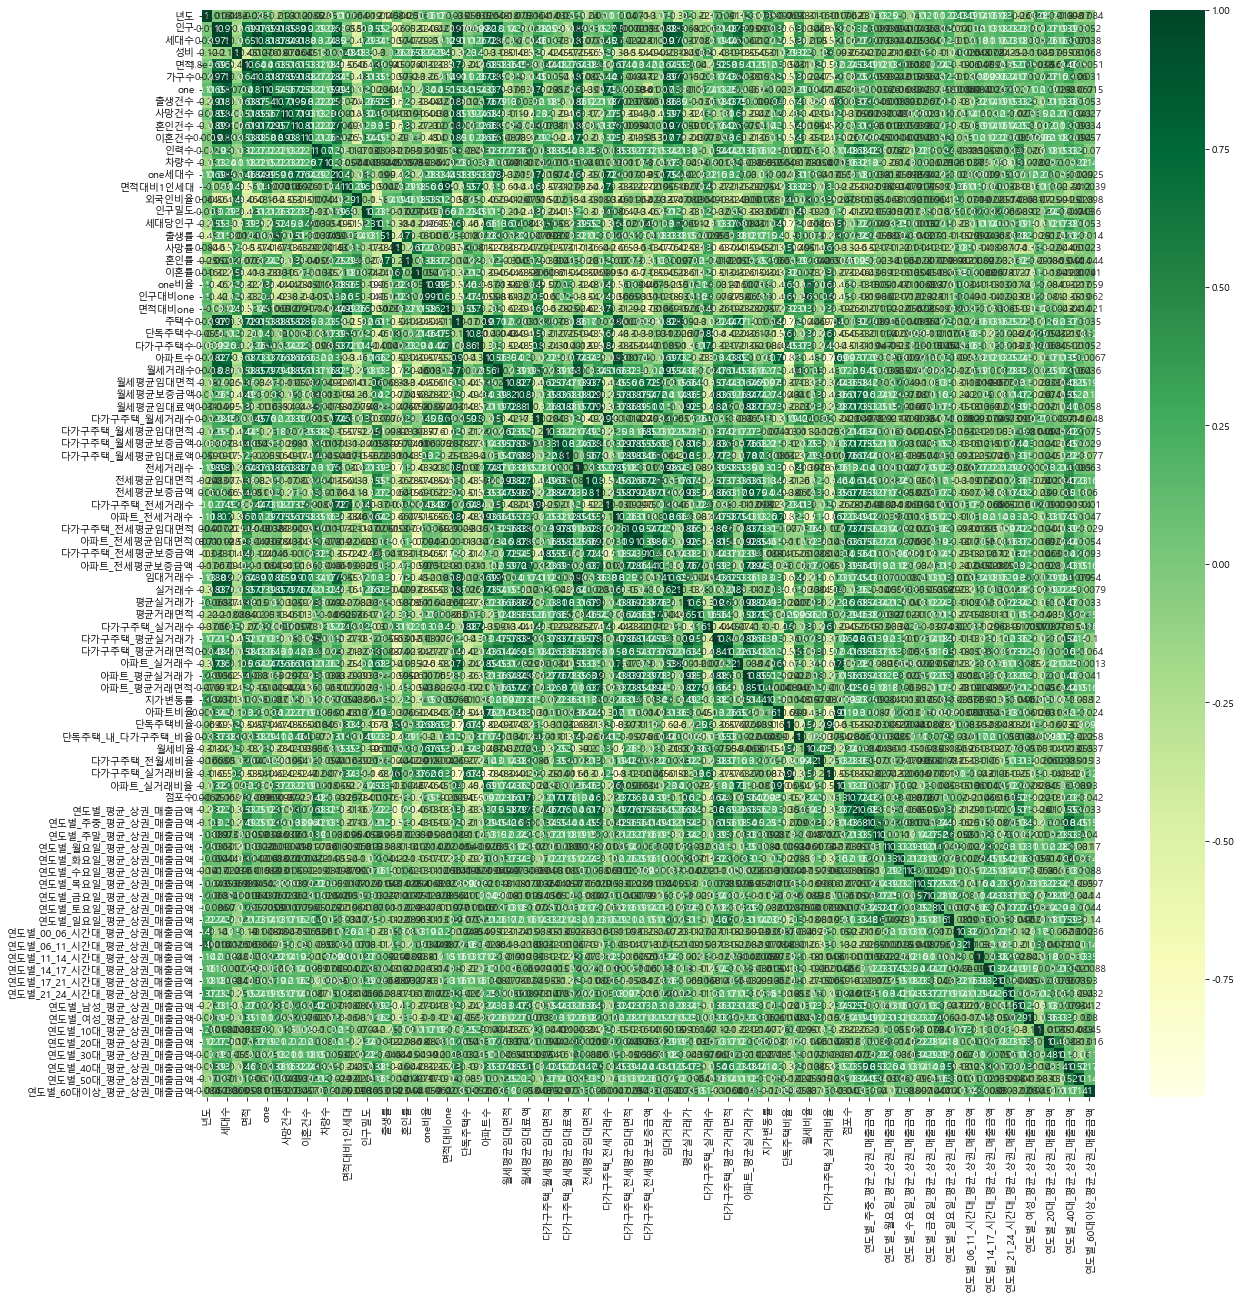

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(seoul[[i for i in seoul.columns if i not in ['자치구','일반쓰레기량', '재활용폐기물량', '음식물류폐기물량']]].corr(),annot=True, cmap='YlGn')
plt.show()

In [7]:
seoul.drop(['연도별_주중_평균_상권_매출금액', '연도별_주말_평균_상권_매출금액','연도별_00_06_시간대_평균_상권_매출금액',
       '연도별_06_11_시간대_평균_상권_매출금액', '연도별_11_14_시간대_평균_상권_매출금액',
       '연도별_14_17_시간대_평균_상권_매출금액', '연도별_17_21_시간대_평균_상권_매출금액',
       '연도별_21_24_시간대_평균_상권_매출금액'], axis=1, inplace=True)

### 단계선택법
- 다중공선성 문제를 해결하기 위해 단계선택법으로 변수를 선정한다.

In [8]:
def stepwise_feature_selection(X, y):
    variables=X.columns.tolist()
    steps = []
    sv_per_step, adjusted_r_squared = [], [] ## 각 스텝별로 선택된 변수들, 수정된 결정계수
    selected_variables = [] ## 선택된 변수들
    
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) 
        for col in remainder: 
            X_train = X[selected_variables+[col]]
            X_train = sm.add_constant(X_train)
            model = sm.OLS(y,X_train).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < 0.05: 
            selected_variables.append(pval.idxmin())
            while len(selected_variables) > 0:
                selected_X = X[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues.iloc[1:]
                max_pval = selected_pval.max()
                if max_pval >= 0.05:   ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y,sm.add_constant(X[selected_variables])).fit(disp=0).rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break
    return selected_variables

## 지수산출식

$$Feature~Importance_{\large{k}} = \frac{Rank_k}{\sum_{j=1}^{N}Rank_j}$$
$$(Rank_k: k\text{번째 변수 회귀계수 절대값의 순위},~ N:\text{변수수})$$

$$Weight_i = \frac{\sum_{k=1}^n Feature~Importance_{ik}}{~\sum_{j=1}^N Feature~Importance_j~}$$
$$(Feature ~Importance_{ik}: i\text{분야의 }k\text{번째 변수의 중요도},~ n: i\text{분야의 변수수},~ N: \text{변수수})$$

- ### LRC
  <br>변수의 중요도를 산출한다.<br>
  https://zephyrus1111.tistory.com/272

In [9]:
def LRC(model):   
    coef = model.params
    LRC_table = pd.DataFrame({'feature_name': coef.index, 'LRC': np.abs(coef.values)/np.sum(np.abs(coef.values))})
    LRC_table['rank'] = LRC_table['LRC'].rank(method='average', ascending=True)
    return LRC_table

- ### Weights of Department

In [10]:
feature_pop = [i for i in pop.columns if i not in ['자치구','년도']]
feature_live = [i for i in live.columns if i not in ['자치구','년도']]
feature_economic = [i for i in economic.columns if i not in ['자치구','년도']]

def Weight(LRC_table):
    for i in [('인구', feature_pop), ('주거', feature_live), ('경제', feature_economic)]:
        print(f'{i[0]} variable:', LRC_table.query('feature_name in @i[1]')['feature_name'].values)
        print(f'{i[0]}:', (LRC_table.query('feature_name in @i[1]')['rank'].sum()/sum(range(1,LRC_table.shape[0]+1))).round(3))

## MultiLinearRegression
- 일반쓰레기량

In [11]:
# X는 독립변수, y는 종속변수입니다.
X = seoul.iloc[:,2:-3]
y = seoul['일반쓰레기량']

In [12]:
# 선택된 변수를 사용하여 모델을 만듭니다.
selected_variables = stepwise_feature_selection(X, y)
formula = "{} ~ {}".format(y.name, ' + '.join(selected_variables))
model_GT = sm.OLS.from_formula(formula, data=seoul).fit()
model_GT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 일반쓰레기량   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     75.06
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           3.81e-30
Time:                        07:02:25   Log-Likelihood:                -298.61
No. Observations:                  75   AIC:                             615.2
Df Residuals:                      66   BIC:                             636.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         49.4460     17.821      2.775      0.007      13.865      85.027
점포수              494.1985     62.350      7.926      0.000     369.712     618.685
주택수              623.2811    126.064      4.944      0.000     371.587     874.975
연도별_평균_상권_매출금액   329.2896     75.151      4.382      0.000     179.246     479.333
아파트_실거래수        -359.3405     78.765     -4.562      0.000    -516.601    -202.080
외국인비율             95.0921     37.331      2.547      0.013      20.558     169.626
다가구주택_실거래비율     -257.6479     70.361     -3.662      0.000    -398.129    -117.167
다가구주택_평균거래면적    -298.9406    103.163     -2.898      0.005    -504.912     -92.969
면적               179.7969     85.376      2.106      0.039       9.338     350.255
==============================================================================
Omnibus:                        9.136   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.773
Skew:                           0.744   Prob(JB):                       0.0124
Kurtosis:                       3.770   Cond. No.                         91.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# 분야별 가중치를 산출한다.
Weight(LRC(model_GT))

인구 variable: ['외국인비율' '면적']
인구: 0.111
주거 variable: ['주택수' '아파트_실거래수' '다가구주택_실거래비율' '다가구주택_평균거래면적']
주거: 0.556
경제 variable: ['점포수' '연도별_평균_상권_매출금액']
경제: 0.311


In [14]:
# 행정동별 위험지수를 산출한다.
gwangjin_GT = gwangjin[['행정동']+model_GT.params.index.tolist()[1:]]
gwangjin_GT['위험지수_일반쓰레기'] = 0.111*gwangjin_GT[['외국인비율', '면적']].mean(axis=1) \
                                     + 0.556*gwangjin_GT[['주택수', '아파트_실거래수', '다가구주택_실거래비율', '다가구주택_평균거래면적']].mean(axis=1) \
                                     + 0.311*gwangjin_GT[['점포수', '연도별_평균_상권_매출금액']].mean(axis=1)
gwangjin_GT = gwangjin_GT[['행정동','위험지수_일반쓰레기']]
gwangjin_GT

,행정동,위험지수_일반쓰레기
0,화양동,0.244448
1,군자동,0.260825
2,중곡1동,0.191409
3,중곡2동,0.179157
4,중곡3동,0.177926
5,중곡4동,0.218197
6,능동,0.249748
7,광장동,0.230181
8,자양1동,0.248497
9,자양2동,0.239512


- 재활용폐기물량

In [15]:
# X는 독립변수, y는 종속변수입니다.
X = seoul.iloc[:,2:-3]
y = seoul['재활용폐기물량']

In [16]:
# 선택된 변수를 사용하여 모델을 만듭니다.
selected_variables = stepwise_feature_selection(X, y)
formula = "{} ~ {} - 1".format(y.name, ' + '.join(selected_variables))
model_RT = sm.OLS.from_formula(formula, data=seoul).fit()
model_RT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                재활용폐기물량   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              545.0
Date:                Fri, 08 Sep 2023   Prob (F-statistic):                    1.31e-44
Time:                        07:02:26   Log-Likelihood:                         -382.38
No. Observations:                  75   AIC:                                      768.8
Df Residuals:                      73   BIC:                                      773.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
임대거래수        1359.7844     74.176     18.332      0.000    1211.951    1507.618
다가구주택_실거래비율   482.9794     73.029      6.614      0.000     337.432     628.526
==============================================================================
Omnibus:                        3.257   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.214
Skew:                           0.482   Prob(JB):                        0.200
Kurtosis:                       2.688   Cond. No.                         2.40
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# 분야별 가중치를 산출한다.
Weight(LRC(model_RT))

인구 variable: []
인구: 0.0
주거 variable: ['임대거래수' '다가구주택_실거래비율']
주거: 1.0
경제 variable: []
경제: 0.0


In [18]:
# 행정동별 위험지수를 산출한다.
gwangjin_RT = gwangjin[['행정동']+model_RT.params.index.tolist()]
gwangjin_RT['위험지수_재활용폐기물'] = 1.0*gwangjin_RT[['임대거래수', '다가구주택_실거래비율']].mean(axis=1)
gwangjin_RT = gwangjin_RT[['행정동','위험지수_재활용폐기물']]
gwangjin_RT

,행정동,위험지수_재활용폐기물
0,화양동,0.185647
1,군자동,0.246696
2,중곡1동,0.301148
3,중곡2동,0.301148
4,중곡3동,0.301148
5,중곡4동,0.301148
6,능동,0.271562
7,광장동,0.055111
8,자양1동,0.241828
9,자양2동,0.241828


- 음식물류폐기물량

In [19]:
# X는 독립변수, y는 종속변수입니다.
X = seoul.iloc[:,2:-3]
y = seoul['음식물류폐기물량']

In [20]:
# 선택된 변수를 사용하여 모델을 만듭니다.
selected_variables = stepwise_feature_selection(X, y)
formula = "{} ~ {} - 1".format(y.name, ' + '.join(selected_variables))
model_FT = sm.OLS.from_formula(formula, data=seoul).fit()
model_FT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               음식물류폐기물량   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              280.9
Date:                Fri, 08 Sep 2023   Prob (F-statistic):                    1.96e-46
Time:                        07:02:28   Log-Likelihood:                         -345.34
No. Observations:                  75   AIC:                                      702.7
Df Residuals:                      69   BIC:                                      716.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
연도별_남성_평균_상권_매출금액      403.3584     64.651      6.239      0.000     274.384     532.333
연도별_60대이상_평균_상권_매출금액   155.9356     40.698      3.832      0.000      74.745     237.126
월세거래수                 1189.6962    111.271     10.692      0.000     967.716    1411.676
다가구주택_전세거래수           -482.5281     79.050     -6.104      0.000    -640.229    -324.827
연도별_토요일_평균_상권_매출금액     189.0201     53.529      3.531      0.001      82.234     295.807
연도별_월요일_평균_상권_매출금액    -111.1327     50.309     -2.209      0.030    -211.497     -10.768
==============================================================================
Omnibus:                       24.956   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.826
Skew:                           0.989   Prob(JB):                     1.13e-15
Kurtosis:                       7.256   Cond. No.                         9.27
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# 분야별 가중치를 산출한다.
Weight(LRC(model_FT))

인구 variable: []
인구: 0.0
주거 variable: ['월세거래수' '다가구주택_전세거래수']
주거: 0.524
경제 variable: ['연도별_남성_평균_상권_매출금액' '연도별_60대이상_평균_상권_매출금액' '연도별_토요일_평균_상권_매출금액'
 '연도별_월요일_평균_상권_매출금액']
경제: 0.476


In [22]:
# 행정동별 위험지수를 산출한다.
gwangjin_FT = gwangjin[['행정동']+model_FT.params.index.tolist()]
gwangjin_FT['위험지수_음식물류폐기물'] = 0.524*gwangjin_FT[['월세거래수', '다가구주택_전세거래수']].mean(axis=1)\
                                        + 0.476*gwangjin_FT[['연도별_남성_평균_상권_매출금액', '연도별_60대이상_평균_상권_매출금액',
                                                              '연도별_토요일_평균_상권_매출금액','연도별_월요일_평균_상권_매출금액']].mean(axis=1)
gwangjin_FT = gwangjin_FT[['행정동','위험지수_음식물류폐기물']]
gwangjin_FT

,행정동,위험지수_음식물류폐기물
0,화양동,0.167602
1,군자동,0.220471
2,중곡1동,0.280400
3,중곡2동,0.264053
4,중곡3동,0.266127
5,중곡4동,0.288224
6,능동,0.247624
7,광장동,0.157188
8,자양1동,0.262729
9,자양2동,0.255278


### Concat results & Save data

In [23]:
result = gwangjin_GT.merge(gwangjin_RT, on='행정동').merge(gwangjin_FT, on='행정동')
result['지수순위_일반쓰레기'] = result['위험지수_일반쓰레기'].rank(method='average', ascending=False)
result['지수순위_재활용폐기물'] = result['위험지수_재활용폐기물'].rank(method='average', ascending=False)
result['지수순위_음식물류폐기물'] = result['위험지수_음식물류폐기물'].rank(method='average', ascending=False)
result

,행정동,위험지수_일반쓰레기,위험지수_재활용폐기물,위험지수_음식물류폐기물,지수순위_일반쓰레기,지수순위_재활용폐기물,지수순위_음식물류폐기물
0,화양동,0.244448,0.185647,0.167602,6.0,14.0,14.0
1,군자동,0.260825,0.246696,0.220471,2.0,6.0,12.0
2,중곡1동,0.191409,0.301148,0.280400,13.0,2.5,2.0
3,중곡2동,0.179157,0.301148,0.264053,14.0,2.5,5.0
4,중곡3동,0.177926,0.301148,0.266127,15.0,2.5,3.0
5,중곡4동,0.218197,0.301148,0.288224,10.0,2.5,1.0
6,능동,0.249748,0.271562,0.247624,4.0,5.0,9.0
7,광장동,0.230181,0.055111,0.157188,9.0,15.0,15.0
8,자양1동,0.248497,0.241828,0.262729,5.0,8.5,6.0
9,자양2동,0.239512,0.241828,0.255278,7.0,8.5,7.0


In [24]:
result.to_csv('../data/ProcessedData/gwangjingu_score.csv', index=False)
gwangjin[['행정동']+model_GT.params.index.tolist()[1:]].to_csv('../data/ProcessedData/gwangjingu_GT.csv', index=False)
gwangjin[['행정동']+model_RT.params.index.tolist()].to_csv('../data/ProcessedData/gwangjingu_RT.csv', index=False)
gwangjin[['행정동']+model_FT.params.index.tolist()].to_csv('../data/ProcessedData/gwangjingu_FT.csv', index=False)